<h2>Classificador Variacional Quântico com Iris Dataset</h2>

<h3>Importando, normalizando e visualizando os dados</h3>

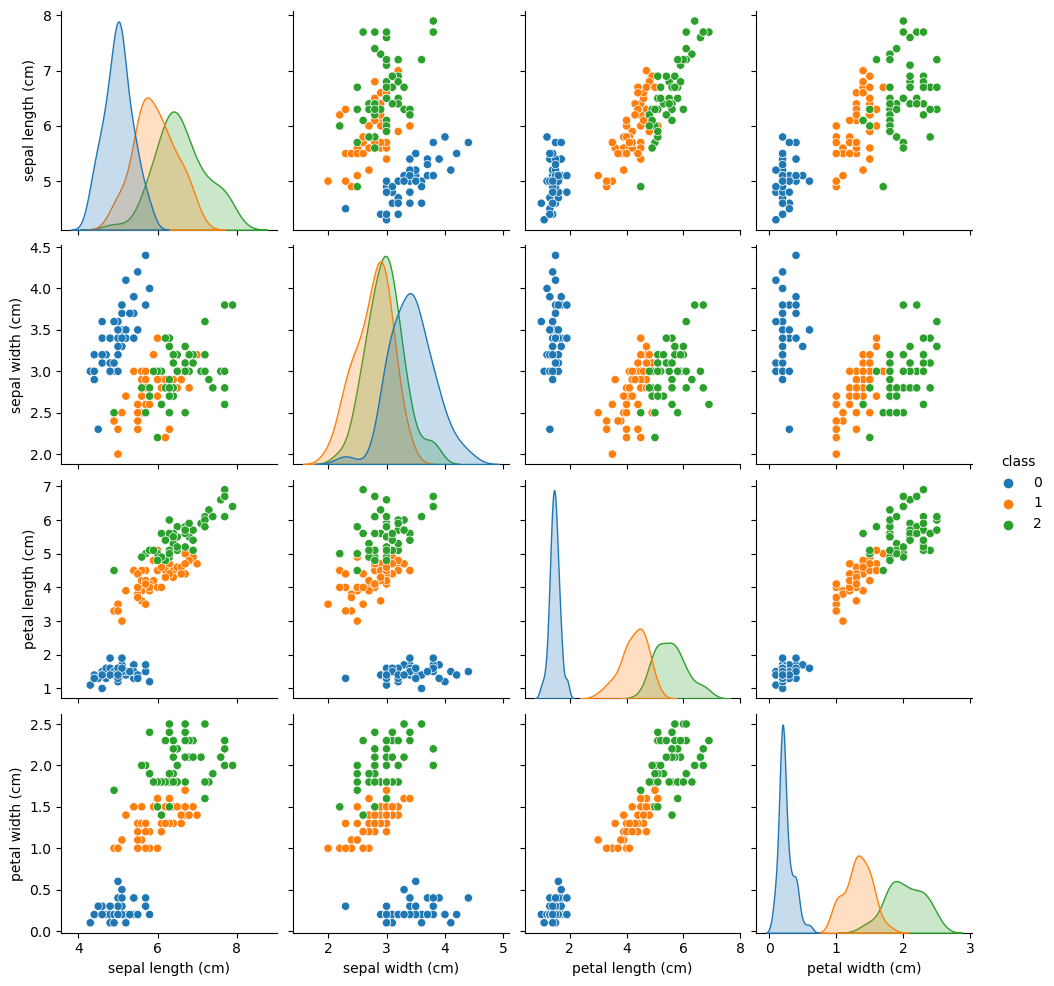

In [1]:
# Importação das bibliotecas necessárias
import timeit
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, label_binarize
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer
from qiskit_machine_learning.algorithms.classifiers import VQC
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
from itertools import cycle
from prettytable import PrettyTable

# Importação dos dados
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

# Normalização
features = MinMaxScaler().fit_transform(features)

# Visualização
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)
sns.pairplot(df, hue="class", palette="tab10")

<h3>Train Test Split</h3>

In [2]:
# Divisão dos dados
TTS_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=TTS_seed)

<h3>Função para treinar o classificador clássico</h3>

In [3]:
def train_classic_classifier():
    svc_classico = OneVsRestClassifier(SVC(kernel="linear", max_iter=100, probability=True))
    svc_classico.fit(train_features, train_labels)
    return svc_classico

<h3>Data Encoding</h3>

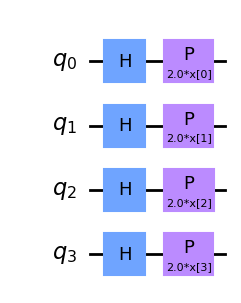

In [4]:
# Número de features (4) define o número de qubits
num_features = features.shape[1]

# Codificação usando ZFeatureMap (circuito de evolução de Pauli de primeira ordem, sem emaranhamento)
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)

# Codificação usando ZZFeatureMap (circuito de evolução de Pauli de segunda ordem, com emaranhamento)
#feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

feature_map.decompose().draw(output="mpl", fold=30)

<h3>Ansatz: o circuito quântico variacional</h3>

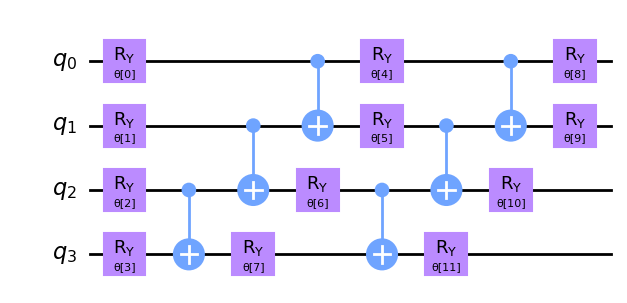

In [5]:
#Circuito variacional com 8 parâmetros (ângulos theta)
#var_circuit = RealAmplitudes(num_qubits=num_features, reps=1)

#Circuito variacional com 12 parâmetros (ângulos theta)
var_circuit = RealAmplitudes(num_qubits=num_features, reps=2)

#Circuito variacional com 16 parâmetros (ângulos theta)
#var_circuit = RealAmplitudes(num_qubits=num_features, reps=3)
var_circuit.decompose().draw(output="mpl", fold=20)

<h3>Escolha do Otimizador</h3>

In [6]:
optimizer = COBYLA(maxiter=100)

<h3>Definindo a callback</h3>

In [7]:
custo_vals = []
theta_vals = []
plt.rcParams["figure.figsize"] = (10,5)

def callback_func(theta_eval, custo_eval):
    clear_output(wait=True)
    theta_vals.append(theta_eval)
    custo_vals.append(custo_eval)
    plt.plot(range(len(custo_vals)), custo_vals)
    plt.show()

<h3>Função para treinar o classificador quântico</h3>

In [8]:
def train_quantum_classifier():
    vqc = VQC(feature_map=feature_map, 
              ansatz=var_circuit, 
              optimizer=optimizer, 
              callback=callback_func, 
              quantum_instance=Aer.get_backend('aer_simulator_statevector'))
    vqc.fit(train_features, train_labels)
    return vqc

<h3>Medindo o tempo de execução</h3>

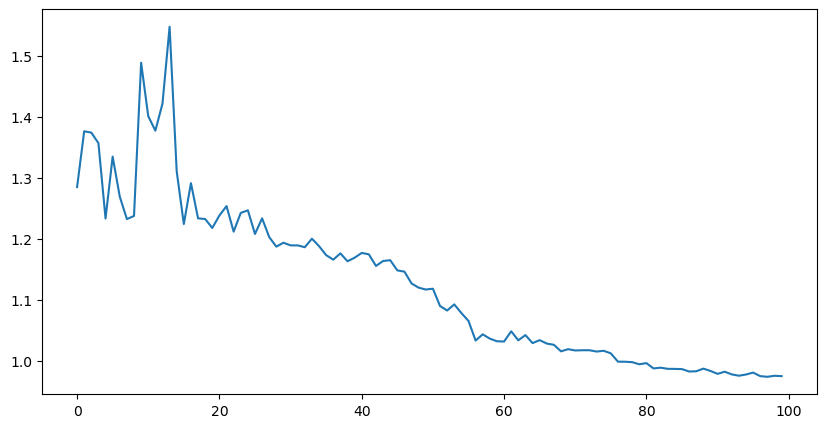

In [9]:
start_time_classic = timeit.default_timer()
svc_classico = train_classic_classifier()
end_time_classic = timeit.default_timer()
time_classic = end_time_classic - start_time_classic

start_time_quantum = timeit.default_timer()
vqc = train_quantum_classifier()
end_time_quantum = timeit.default_timer()
time_quantum = end_time_quantum - start_time_quantum

<h3>Avaliando os classificadores</h3>

In [10]:
train_predicts_classic = svc_classico.predict(train_features)
test_predicts_classic = svc_classico.predict(test_features)

In [11]:
train_predicts_quantum = vqc.predict(train_features)
test_predicts_quantum = vqc.predict(test_features)

<h3>Cálculo das curvas ROC para os classificadores<h3>

In [12]:
# Binarização dos rótulos para cálculos de especificidade e AUROC
n_classes = len(np.unique(labels))
train_labels_bin = label_binarize(train_labels, classes=[*range(n_classes)])
test_labels_bin = label_binarize(test_labels, classes=[*range(n_classes)])

# Binarizamos as previsões para cálculos de especificidade e AUROC
train_predicts_classic_bin = label_binarize(train_predicts_classic, classes=[*range(n_classes)])
test_predicts_classic_bin = label_binarize(test_predicts_classic, classes=[*range(n_classes)])
train_predicts_quantum_bin = label_binarize(train_predicts_quantum, classes=[*range(n_classes)])
test_predicts_quantum_bin = label_binarize(test_predicts_quantum, classes=[*range(n_classes)])

# Criando dicionários para treinamento
fpr_classic_train = dict()
tpr_classic_train = dict()
roc_auc_classic_train = dict()

fpr_quantum_train = dict()
tpr_quantum_train = dict()
roc_auc_quantum_train = dict()

# Criando dicionários para teste
fpr_classic = dict()
tpr_classic = dict()
roc_auc_classic = dict()

fpr_quantum = dict()
tpr_quantum = dict()
roc_auc_quantum = dict()

# Classificador clássico
for i in range(n_classes):
    fpr_classic[i], tpr_classic[i], _ = roc_curve(test_labels_bin[:, i], test_predicts_classic_bin[:, i])
    roc_auc_classic[i] = auc(fpr_classic[i], tpr_classic[i])

    # Adicionando cálculos para o treinamento
    fpr_classic_train[i], tpr_classic_train[i], _ = roc_curve(train_labels_bin[:, i], train_predicts_classic_bin[:, i])
    roc_auc_classic_train[i] = auc(fpr_classic_train[i], tpr_classic_train[i])

# Classificador quântico
for i in range(n_classes):
    fpr_quantum[i], tpr_quantum[i], _ = roc_curve(test_labels_bin[:, i], test_predicts_quantum_bin[:, i])
    roc_auc_quantum[i] = auc(fpr_quantum[i], tpr_quantum[i])

    # Adicionando cálculos para o treinamento
    fpr_quantum_train[i], tpr_quantum_train[i], _ = roc_curve(train_labels_bin[:, i], train_predicts_quantum_bin[:, i])
    roc_auc_quantum_train[i] = auc(fpr_quantum_train[i], tpr_quantum_train[i])

# Calculando micro-average ROC curve e ROC area para teste
fpr_classic["micro"], tpr_classic["micro"], _ = roc_curve(test_labels_bin.ravel(), test_predicts_classic_bin.ravel())
roc_auc_classic["micro"] = auc(fpr_classic["micro"], tpr_classic["micro"])

fpr_quantum["micro"], tpr_quantum["micro"], _ = roc_curve(test_labels_bin.ravel(), test_predicts_quantum_bin.ravel())
roc_auc_quantum["micro"] = auc(fpr_quantum["micro"], tpr_quantum["micro"])

# Adicionando cálculos para o treinamento
fpr_classic_train["micro"], tpr_classic_train["micro"], _ = roc_curve(train_labels_bin.ravel(), train_predicts_classic_bin.ravel())
roc_auc_classic_train["micro"] = auc(fpr_classic_train["micro"], tpr_classic_train["micro"])

fpr_quantum_train["micro"], tpr_quantum_train["micro"], _ = roc_curve(train_labels_bin.ravel(), train_predicts_quantum_bin.ravel())
roc_auc_quantum_train["micro"] = auc(fpr_quantum_train["micro"], tpr_quantum_train["micro"])

<h3>Função para calcular a especificidade<h3>

In [13]:
def specificity_score(y_true, y_pred):
    # Obtem a matriz de confusão para cada rótulo
    cms = multilabel_confusion_matrix(y_true, y_pred)
    
    # Calcula a especificidade para cada rótulo e retorna a média
    specificities = [tn / (tn + fp) if (tn + fp) > 0 else 0 for tn, fp, fn, tp in cms.reshape(-1, 4)]
    return np.mean(specificities)

<h3>Métricas para o classificador clássico</h3>

In [14]:
print("Métricas para o classificador clássico:")
print("Tempo de treinamento:", time_classic, "segundos")
print("Relatório de classificação (treino):")
print(classification_report(train_labels, train_predicts_classic, digits=4))
print("Acurácia (Treino):", accuracy_score(train_labels, train_predicts_classic))
print("Especificidade (Treino):", specificity_score(train_labels_bin, train_predicts_classic_bin))
print("Relatório de classificação (teste):")
print(classification_report(test_labels, test_predicts_classic, digits=4))
print("Acurácia (Teste):", accuracy_score(test_labels, test_predicts_classic))
print("Especificidade (Teste):", specificity_score(test_labels_bin, test_predicts_classic_bin))

Métricas para o classificador clássico:
Tempo de treinamento: 0.009385700002894737 segundos
Relatório de classificação (treino):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        34
           1     1.0000    0.6905    0.8169        42
           2     0.7347    1.0000    0.8471        36

    accuracy                         0.8839       112
   macro avg     0.9116    0.8968    0.8880       112
weighted avg     0.9147    0.8839    0.8822       112

Acurácia (Treino): 0.8839285714285714
Especificidade (Treino): 0.9429824561403509
Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     0.8750    0.8750    0.8750         8
           2     0.9286    0.9286    0.9286        14

    accuracy                         0.9474        38
   macro avg     0.9345    0.9345    0.9345        38
weighted avg     0.9474    0.9474    0.9474   

<h3>Métricas para o classificador quântico</h3>

In [15]:
print("\nMétricas para o classificador quântico:")
print("Tempo de treinamento:", time_quantum, "segundos")
print("Relatório de classificação (treino):")
print(classification_report(train_labels, train_predicts_quantum, digits=4))
print("Acurácia (Treino):", accuracy_score(train_labels, train_predicts_quantum))
print("Especificidade (Treino):", specificity_score(train_labels, train_predicts_quantum))
print("Relatório de classificação (teste):")
print(classification_report(test_labels, test_predicts_quantum, digits=4))
print("Acurácia (Teste):", accuracy_score(test_labels, test_predicts_quantum))
print("Especificidade (Teste):", specificity_score(test_labels, test_predicts_quantum))


Métricas para o classificador quântico:
Tempo de treinamento: 70.5708057999982 segundos
Relatório de classificação (treino):
              precision    recall  f1-score   support

           0     0.9444    1.0000    0.9714        34
           1     0.7059    0.8571    0.7742        42
           2     0.8400    0.5833    0.6885        36

    accuracy                         0.8125       112
   macro avg     0.8301    0.8135    0.8114       112
weighted avg     0.8214    0.8125    0.8065       112

Acurácia (Treino): 0.8125
Especificidade (Treino): 0.9024805603752971
Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9412    1.0000    0.9697        16
           1     0.5385    0.8750    0.6667         8
           2     1.0000    0.5714    0.7273        14

    accuracy                         0.8158        38
   macro avg     0.8265    0.8155    0.7879        38
weighted avg     0.8781    0.8158    0.8166        38

Acurác

<h3>Plotando as curvas ROC<h3>

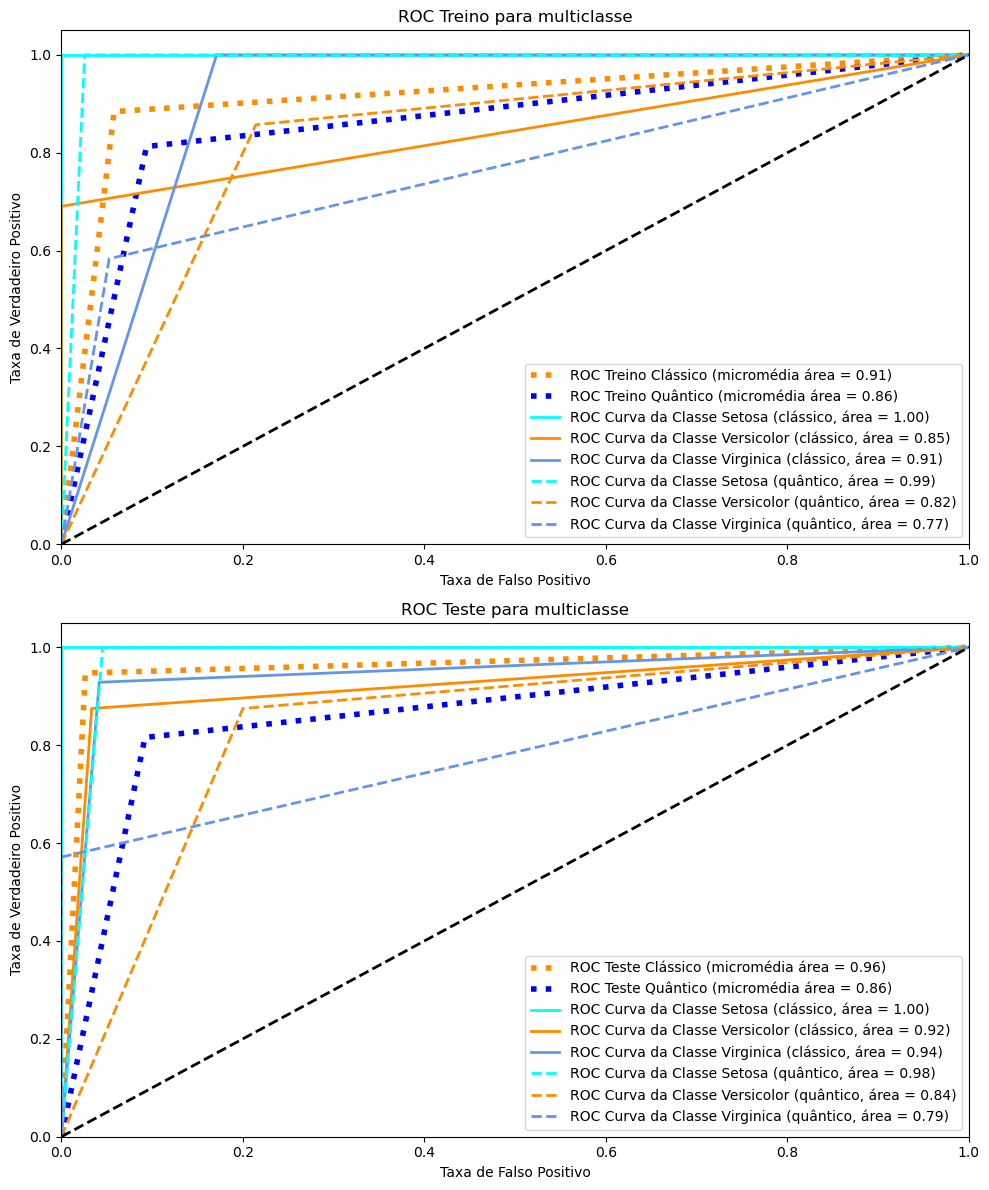

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
lw = 2

# Mapeamento de índices para nomes de classes
class_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# ROC Curvas para treino
axs[0].plot(fpr_classic_train["micro"], tpr_classic_train["micro"],
         label='ROC Treino Clássico (micromédia área = {0:0.2f})'
               ''.format(roc_auc_classic_train["micro"]),
         color='darkorange', linestyle=':', linewidth=4)

axs[0].plot(fpr_quantum_train["micro"], tpr_quantum_train["micro"],
         label='ROC Treino Quântico (micromédia área = {0:0.2f})'
               ''.format(roc_auc_quantum_train["micro"]),
         color='blue', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    axs[0].plot(fpr_classic_train[i], tpr_classic_train[i], color=color, lw=lw,
             label='ROC Curva da Classe {0} (clássico, área = {1:0.2f})'
             ''.format(class_names[i], roc_auc_classic_train[i]))

for i, color in zip(range(n_classes), colors):
    axs[0].plot(fpr_quantum_train[i], tpr_quantum_train[i], color=color, lw=lw, linestyle='--',
             label='ROC Curva da Classe {0} (quântico, área = {1:0.2f})'
             ''.format(class_names[i], roc_auc_quantum_train[i]))

axs[0].plot([0, 1], [0, 1], 'k--', lw=lw)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('Taxa de Falso Positivo')
axs[0].set_ylabel('Taxa de Verdadeiro Positivo')
axs[0].set_title('ROC Treino para multiclasse')
axs[0].legend(loc="lower right")

# ROC Curvas para teste
axs[1].plot(fpr_classic["micro"], tpr_classic["micro"],
         label='ROC Teste Clássico (micromédia área = {0:0.2f})'
               ''.format(roc_auc_classic["micro"]),
         color='darkorange', linestyle=':', linewidth=4)

axs[1].plot(fpr_quantum["micro"], tpr_quantum["micro"],
         label='ROC Teste Quântico (micromédia área = {0:0.2f})'
               ''.format(roc_auc_quantum["micro"]),
         color='blue', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    axs[1].plot(fpr_classic[i], tpr_classic[i], color=color, lw=lw,
             label='ROC Curva da Classe {0} (clássico, área = {1:0.2f})'
             ''.format(class_names[i], roc_auc_classic[i]))

for i, color in zip(range(n_classes), colors):
    axs[1].plot(fpr_quantum[i], tpr_quantum[i], color=color, lw=lw, linestyle='--',
             label='ROC Curva da Classe {0} (quântico, área = {1:0.2f})'
             ''.format(class_names[i], roc_auc_quantum[i]))

axs[1].plot([0, 1], [0, 1], 'k--', lw=lw)
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Taxa de Falso Positivo')
axs[1].set_ylabel('Taxa de Verdadeiro Positivo')
axs[1].set_title('ROC Teste para multiclasse')
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

<h3>Matrizes de confusão do clássico e quântico</h3>

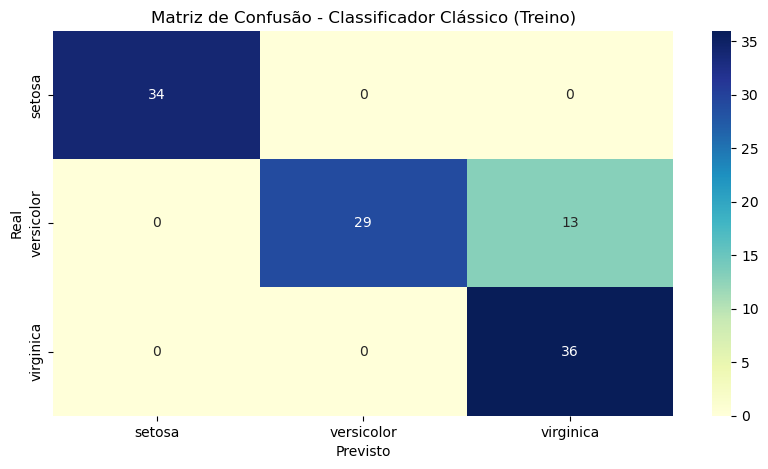

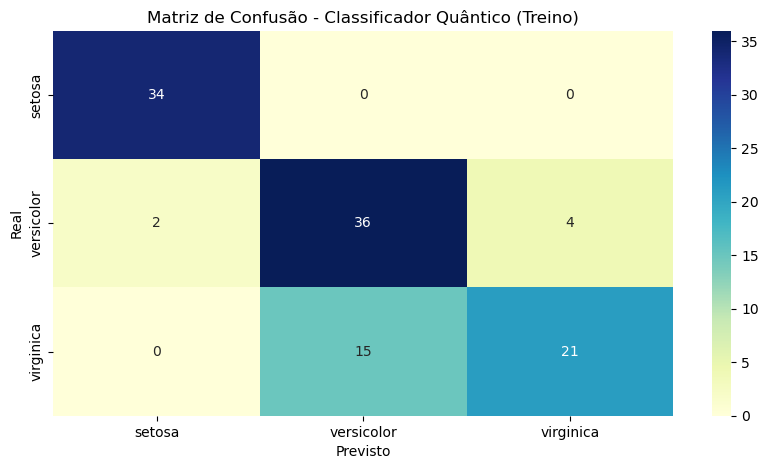

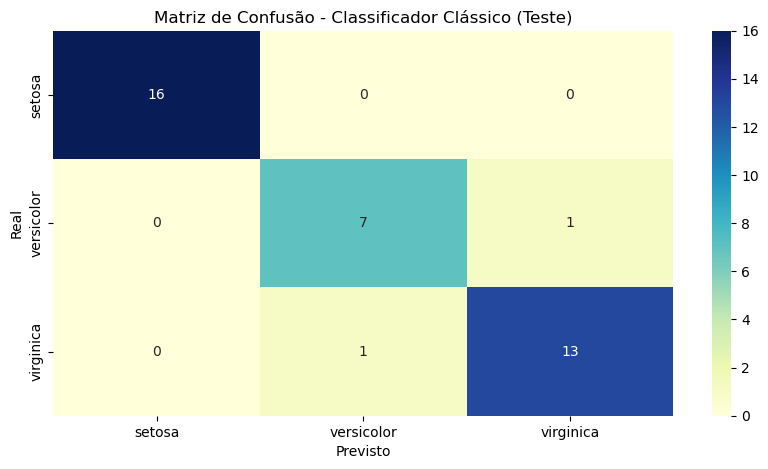

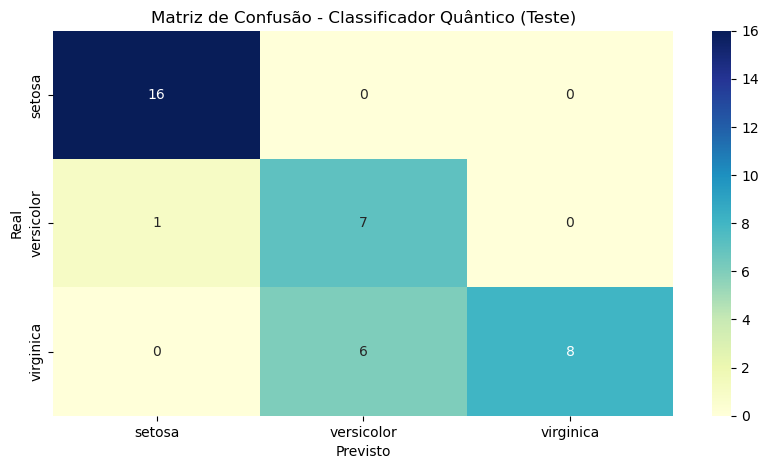

In [17]:
# Função para mostrar a matriz de confusão
def show_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, columns=classes, index=classes)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

# Chamando a função para mostrar a matriz de confusão para os classificadores clássico e quântico
show_confusion_matrix(train_labels, train_predicts_classic, iris_data.target_names, "Matriz de Confusão - Classificador Clássico (Treino)")
show_confusion_matrix(train_labels, train_predicts_quantum, iris_data.target_names, "Matriz de Confusão - Classificador Quântico (Treino)")
show_confusion_matrix(test_labels, test_predicts_classic, iris_data.target_names, "Matriz de Confusão - Classificador Clássico (Teste)")
show_confusion_matrix(test_labels, test_predicts_quantum, iris_data.target_names, "Matriz de Confusão - Classificador Quântico (Teste)")

<h3>Avaliação do comportamento do classificador em função do tamanho do conjunto de treinamento</h3>

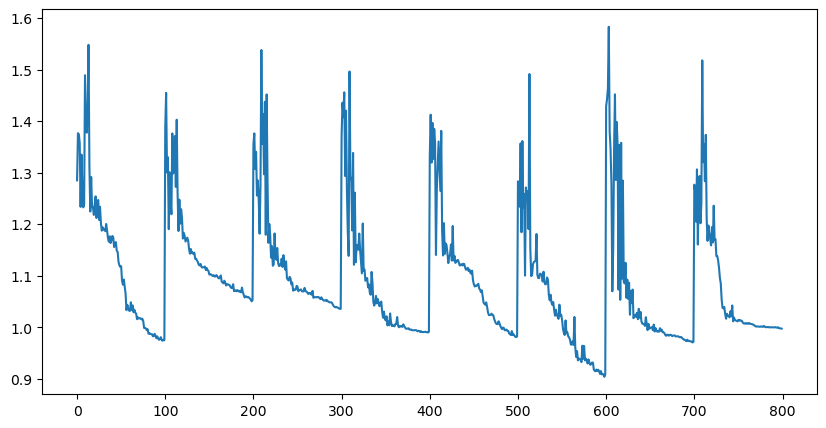

+------------+-----------+----------------+---------------+-------------------+------------------+--------------+-------------+----------+---------+-------------+------------+
| Train Size |   Model   | Train Accuracy | Test Accuracy | Train Specificity | Test Specificity | Train Recall | Test Recall | Train F1 | Test F1 | Train AUROC | Test AUROC |
+------------+-----------+----------------+---------------+-------------------+------------------+--------------+-------------+----------+---------+-------------+------------+
|    0.2     | Classical |     0.633      |     0.733     |       0.796       |      0.871       |    0.633     |    0.733    |  0.633   |  0.733  |    0.731    |   0.799    |
|    0.2     |  Quantum  |     0.767      |     0.742     |       0.863       |      0.874       |    0.767     |    0.742    |  0.767   |  0.742  |    0.825    |   0.811    |
|    0.3     | Classical |     0.844      |     0.867     |       0.918       |      0.934       |    0.844     |    0.8

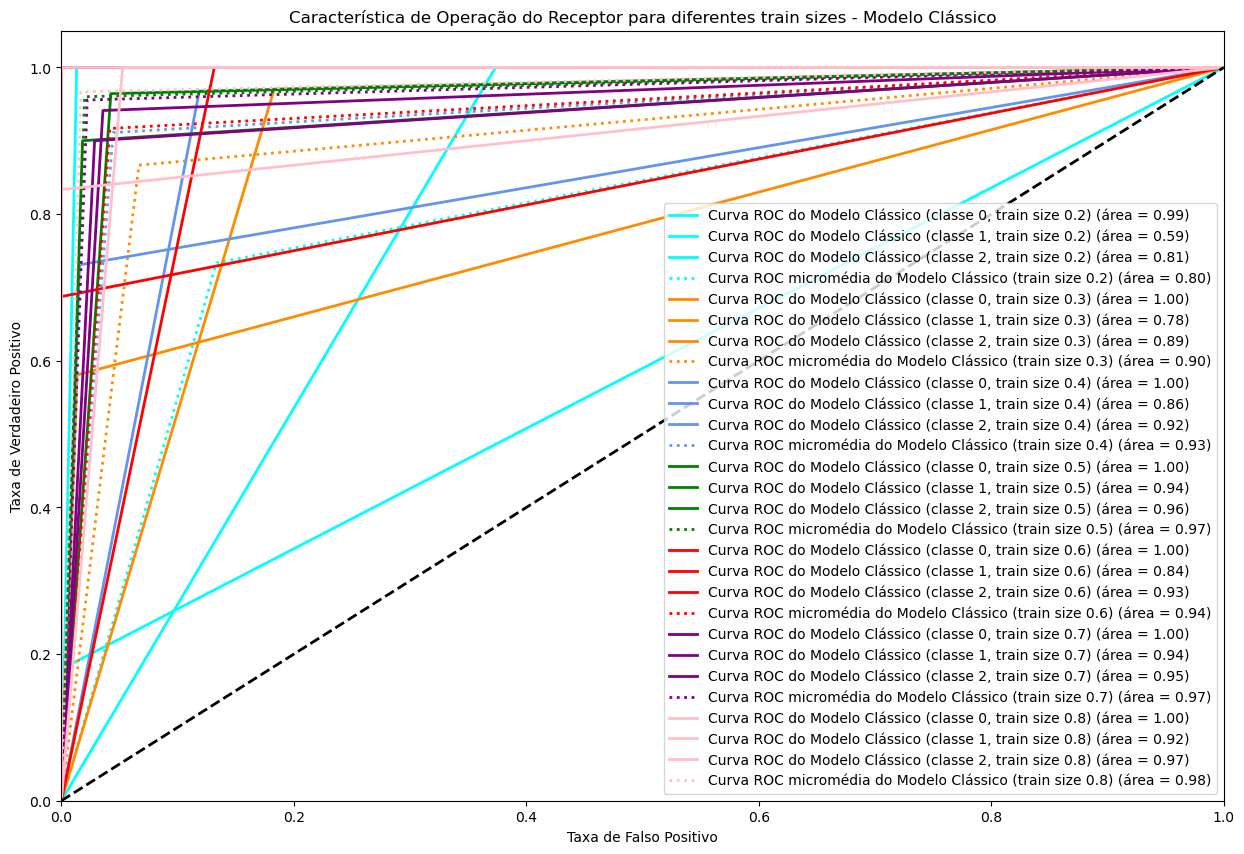

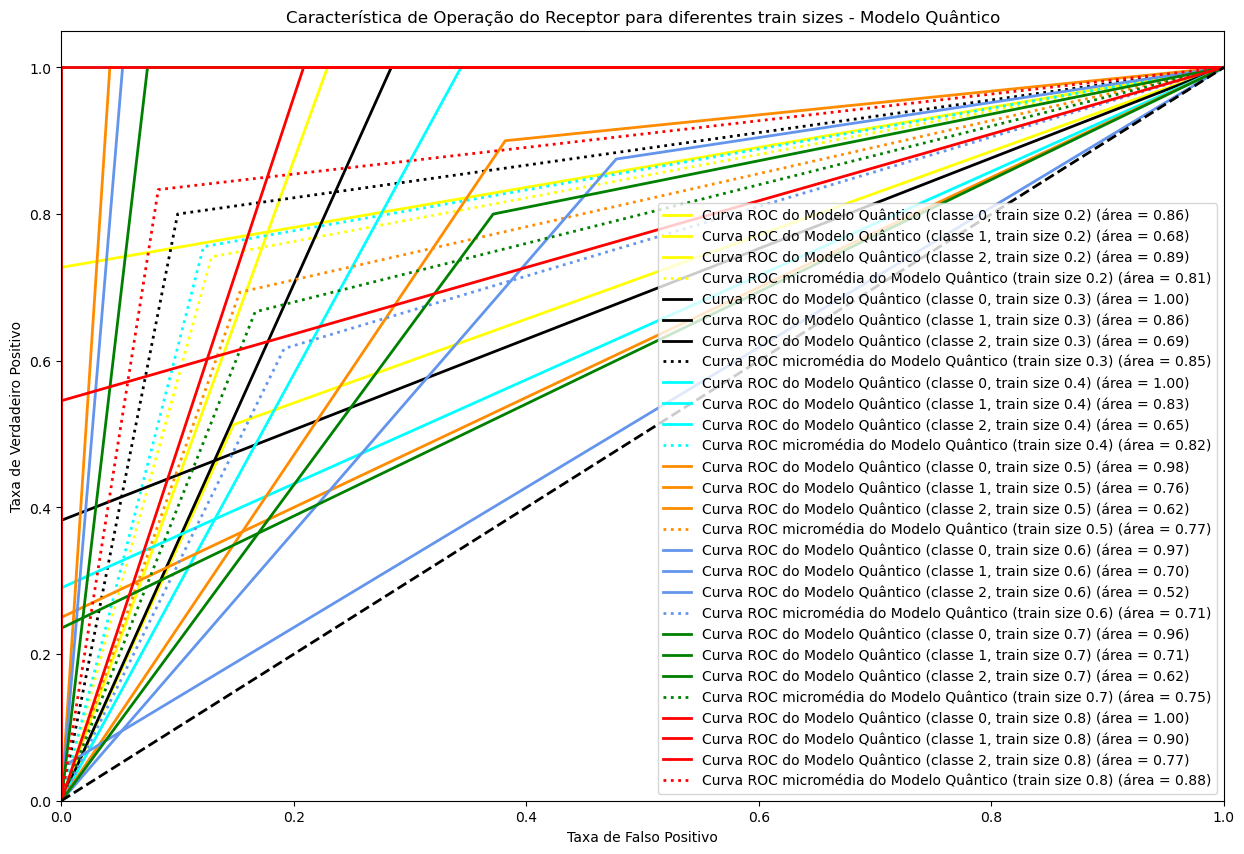

In [18]:
# Inicialize a tabela de resultados
ptable = PrettyTable()
ptable.field_names = ["Train Size", "Model", "Train Accuracy", "Test Accuracy", "Train Specificity", "Test Specificity", "Train Recall", "Test Recall", "Train F1", "Test F1", "Train AUROC", "Test AUROC"]

train_sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Inicializando os dicionários para armazenar os resultados
fpr_dict_classic = dict()
tpr_dict_classic = dict()
roc_auc_dict_classic = dict()

fpr_dict_quantum = dict()
tpr_dict_quantum = dict()
roc_auc_dict_quantum = dict()

# Definindo o ciclo de cores para as curvas ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'yellow', 'black'])

for train_size in train_sizes:
    # Split de treino e teste com o novo tamanho
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size=train_size, random_state=TTS_seed)

    # Treinamento dos classificadores
    svc_classico = train_classic_classifier()
    vqc = train_quantum_classifier()

    # Previsões
    train_predicts_classic = svc_classico.predict(train_features)
    test_predicts_classic = svc_classico.predict(test_features)
    train_predicts_quantum = vqc.predict(train_features)
    test_predicts_quantum = vqc.predict(test_features)

    # Binarizando rótulos e previsões
    train_labels_bin = label_binarize(train_labels, classes=[*range(n_classes)])
    test_labels_bin = label_binarize(test_labels, classes=[*range(n_classes)])

    # Loop para cada modelo
    for i, (model_name, train_pred, test_pred) in enumerate([("Classical", train_predicts_classic, test_predicts_classic), ("Quantum", train_predicts_quantum, test_predicts_quantum)]):
        train_pred_bin = label_binarize(train_pred, classes=[*range(n_classes)])
        test_pred_bin = label_binarize(test_pred, classes=[*range(n_classes)])
        
        # Calculate ROC curve and ROC area for each class
        if model_name == "Classical":
            fpr_dict = fpr_dict_classic
            tpr_dict = tpr_dict_classic
            roc_auc_dict = roc_auc_dict_classic
        else:
            fpr_dict = fpr_dict_quantum
            tpr_dict = tpr_dict_quantum
            roc_auc_dict = roc_auc_dict_quantum
            
        fpr_dict[train_size] = dict()
        tpr_dict[train_size] = dict()
        roc_auc_dict[train_size] = dict()

        for j in range(n_classes):
            fpr_dict[train_size][j], tpr_dict[train_size][j], _ = roc_curve(test_labels_bin[:, j], test_pred_bin[:, j])
            roc_auc_dict[train_size][j] = auc(fpr_dict[train_size][j], tpr_dict[train_size][j])

        # Calcular micro-average curva ROC e área ROC
        fpr_dict[train_size]["micro"], tpr_dict[train_size]["micro"], _ = roc_curve(test_labels_bin.ravel(), test_pred_bin.ravel())
        roc_auc_dict[train_size]["micro"] = auc(fpr_dict[train_size]["micro"], tpr_dict[train_size]["micro"])
            
        # Calcular as métricas de desempenho
        train_accuracy = accuracy_score(train_labels, train_pred)
        test_accuracy = accuracy_score(test_labels, test_pred)
        train_specificity = specificity_score(train_labels, train_pred)
        test_specificity = specificity_score(test_labels, test_pred)
        train_recall = recall_score(train_labels, train_pred, average='micro')
        test_recall = recall_score(test_labels, test_pred, average='micro')
        train_f1 = f1_score(train_labels, train_pred, average='micro')
        test_f1 = f1_score(test_labels, test_pred, average='micro')
        train_auroc = np.mean([roc_auc_score(train_labels_bin[:, j], train_pred_bin[:, j]) for j in range(n_classes)])
        test_auroc = np.mean([roc_auc_score(test_labels_bin[:, j], test_pred_bin[:, j]) for j in range(n_classes)])


        # Adicionar os resultados à tabela
        ptable.add_row([train_size, model_name,
                        f"{train_accuracy:.3f}", f"{test_accuracy:.3f}",
                        f"{train_specificity:.3f}", f"{test_specificity:.3f}",
                        f"{train_recall:.3f}", f"{test_recall:.3f}",
                        f"{train_f1:.3f}", f"{test_f1:.3f}",
                        f"{train_auroc:.3f}", f"{test_auroc:.3f}"])

# Imprimir a tabela de resultados
print(ptable)

# Plotando curvas ROC pro clássico
plt.figure(figsize=(15,10))
for i, color in zip(fpr_dict_classic.keys(), colors):
    for j in range(n_classes):
        plt.plot(fpr_dict_classic[i][j], tpr_dict_classic[i][j], color=color, lw=2,
                 label=f'Curva ROC do Modelo Clássico (classe {j}, train size {i}) (área = {roc_auc_dict_classic[i][j]:0.2f})')
    plt.plot(fpr_dict_classic[i]["micro"], tpr_dict_classic[i]["micro"], color=color, lw=2, linestyle=':',
             label=f'Curva ROC micromédia do Modelo Clássico (train size {i}) (área = {roc_auc_dict_classic[i]["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Característica de Operação do Receptor para diferentes train sizes - Modelo Clássico')
plt.legend(loc="lower right")
plt.show()

# Plotando curvas ROC pro quântico
plt.figure(figsize=(15,10))
for i, color in zip(fpr_dict_quantum.keys(), colors):
    for j in range(n_classes):
        plt.plot(fpr_dict_quantum[i][j], tpr_dict_quantum[i][j], color=color, lw=2,
                 label=f'Curva ROC do Modelo Quântico (classe {j}, train size {i}) (área = {roc_auc_dict_quantum[i][j]:0.2f})')
    plt.plot(fpr_dict_quantum[i]["micro"], tpr_dict_quantum[i]["micro"], color=color, lw=2, linestyle=':',
             label=f'Curva ROC micromédia do Modelo Quântico (train size {i}) (área = {roc_auc_dict_quantum[i]["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Característica de Operação do Receptor para diferentes train sizes - Modelo Quântico')
plt.legend(loc="lower right")
plt.show()